# Group Data Generation Example
For the group data generation, the probability to have a true positive label is dependant on the previous predictions of the whole group. The whole group moves towards positive or negative cluster depending on previous predictions.

In [1]:
import sys
import numpy as np
sys.path.append("../")

from fairensics.methods import FairDisparateImpact, AccurateDisparateImpact

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from aif360.algorithms.inprocessing import PrejudiceRemover

from long_term_fairness.ltf_plot import LongTermFairnessPlot
from long_term_fairness.ltf_data.group_data_generator import GroupDataGenerator
from long_term_fairness.ltf_aif.longterm_aif import AifLongTermMetric, AifLongTermPrediction

Import error: No module named 'tensorflow'


In [2]:
generator = GroupDataGenerator(mean_pos=[0, 1],
                               mean_neg=[12, 11],
                               num_positive_label=100,
                               num_negative_label=100,
                               discrimination_factor=.9)

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Unconstrained Example

In [4]:
class CLF:
    def __init__(self, clf=LogisticRegression()):
        self.c = clf
    def predict(self, X, X_s):
        return self.c.predict(X)
    def fit(self, X, X_s, y):
        self.c.fit(X, y)     

In [5]:
metric = AifLongTermMetric()

In [6]:
#clf = AifLongTermPrediction(PrejudiceRemover())
clf = CLF(LinearSVC())

In [7]:
l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 14], y_lim=[-1, 14])

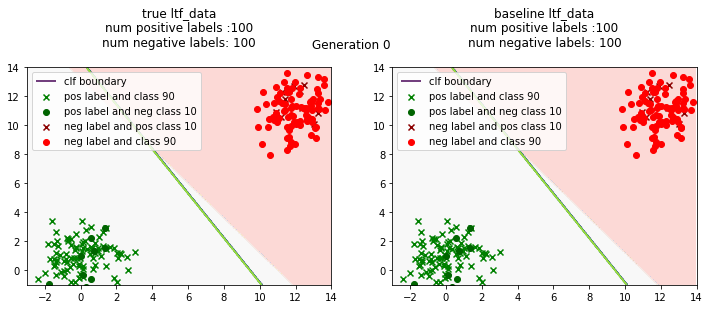

In [8]:
l.init_data()
l.plot_generation()

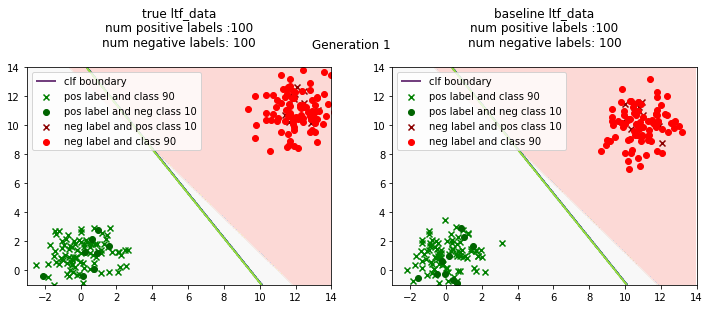

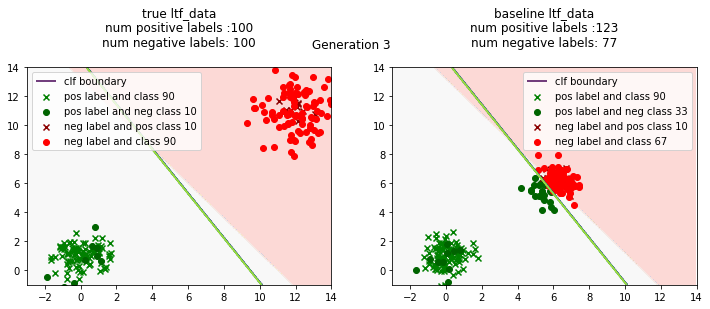

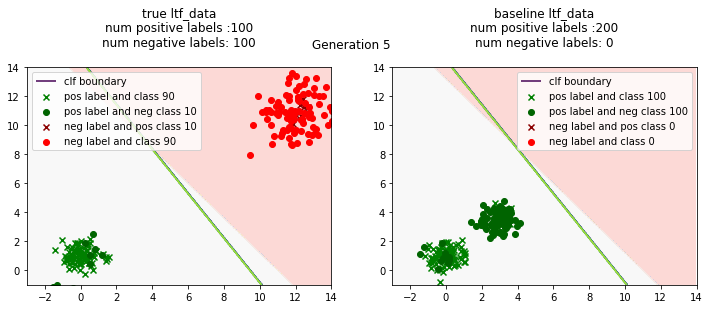

In [9]:
for i in range(6):

    l.run_generation()
    l.run_baseline_generation()
    if i % 2 == 0:
        l.plot_generation()

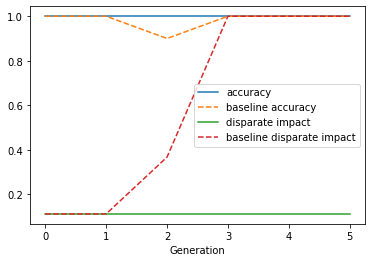

In [10]:
l.plot_ltf(["accuracy", "disparate impact"])

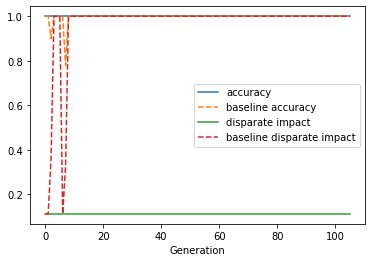

In [11]:
l.run(100)
l.plot_ltf(["accuracy", "disparate impact"])

## Constrained Example

In [12]:
class FairCLF:
    def predict(self, X, X_s):
        pred = [5, -12] @ X.T + 50
        
        pred[pred>0] = 1
        pred[pred<0] = 0
        
        return np.sign(pred)
    def fit(self, X, X_s, y):
        pass

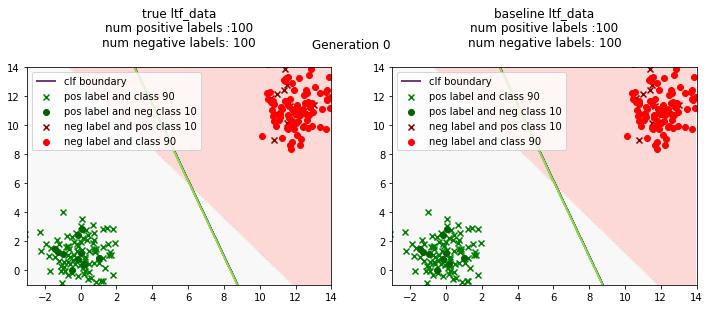

In [13]:
#clf = FairCLF()
clf = AifLongTermPrediction(FairDisparateImpact())

l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 14], y_lim=[-1, 14])

l.init_data()
l.plot_generation()

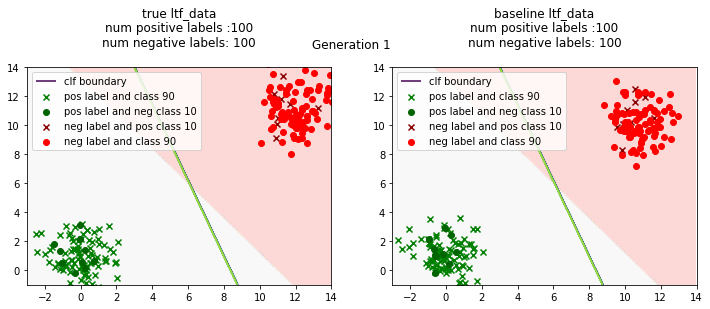

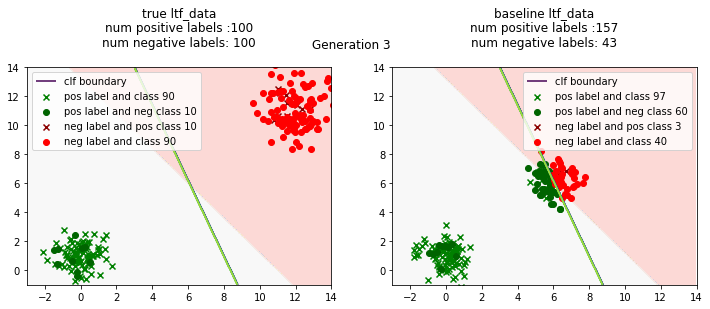

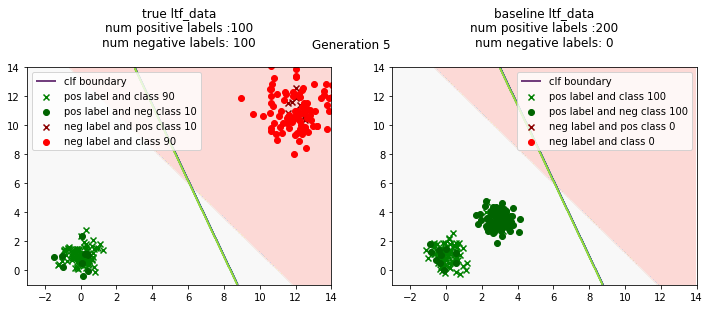

In [14]:
for i in range(6):
    l.run_generation()
    l.run_baseline_generation()
    if i % 2 == 0:
        l.plot_generation()

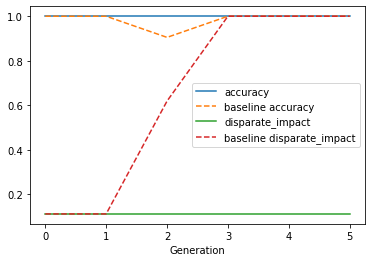

In [15]:
l.plot_ltf(metric._metrics)

In [ ]:
l.run(1000)
l.plot_ltf(metric._metrics)

In [ ]:
l.plot_generation()